# Model Evaluation Protocol
The Evaluation Protocol Will Evaluate the best hyperparameter configuration for each Learning Algorithm used in the model Selection.

Therefore, following Steps will be performed:
1. Train a model for each learning algorithm using the optimal hyperparameter configuration
-- Train the model on the whole cross validation dataset
2. Test each models performance using F1-Micro Score
-- The test will be performed using the test dataset
3. Analyze the Precision Recall Curve as well as the OvR ROC Curves for each model to determine whether one model is clearly better than the others
4. Determine the best performing model(s)/algorithm(s)


In [36]:
import pandas as pd
from pandas import DataFrame


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, PrecisionRecallDisplay, RocCurveDisplay

# Load Data

In [6]:
path_cross_val_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\cross_validation_data.csv"
path_test_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\test_data.csv"

cross_validation_data: DataFrame = pd.read_csv(path_cross_val_data, index_col="index")
x_cross_val: DataFrame = cross_validation_data.drop("target", axis=1)
y_cross_val: DataFrame = cross_validation_data.target

test_data: DataFrame = pd.read_csv(path_test_data, index_col="index")
x_test: DataFrame = test_data.drop("target", axis=1)
y_test: DataFrame = test_data.target

# also for scaled
path_scaled_cross_val_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\scaled_cross_validation_data.csv"
path_scaled_test_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\scaled_test_data.csv"

scaled_cross_validation_data: DataFrame = pd.read_csv(path_scaled_cross_val_data, index_col="index")
x_cross_val_scaled: DataFrame = scaled_cross_validation_data.drop("target", axis=1)
y_cross_val_scaled: DataFrame = scaled_cross_validation_data.target

scaled_test_data: DataFrame = pd.read_csv(path_scaled_test_data, index_col="index")
x_test_scaled: DataFrame = scaled_test_data.drop("target", axis=1)
y_test_scaled: DataFrame = scaled_test_data.target

# Final Hyperparameter Combination for each of the trained Models

| Model Name | Class Weight |     Loss      | Max_Iter | Regularizer | Regularization Weight | F1 Score (Micro AVG) |
|------------|:------------:|:-------------:|:--------:|:-----------:|:---------------------:|:--------------------:|
| SVM        |   balanced   | squared_hinge |   1000   |     l2      |          1.0          |        0.9043        |

<br>
<br>

| Model Name    | Class Weight | Criterion | Max Depth | Min Sample Leaf | Number of Estimators | F1 Score (Micro AVG) |
|---------------|:------------:|:---------:|:---------:|:---------------:|:--------------------:|:--------------------:|
| Random Forest |   balanced   |  Entropy  |    200    |        2        |         200          |        0.9788        |

<br>
<br>

| Model Name    | Class Weight | Max Depth  | Min Sample Leaf | Criterion | F1 Score (Micro AVG) |
|---------------|:------------:|:----------:|:---------------:|:---------:|:--------------------:|
| Decision Tree |   balanced   |     10     |        2        |   gini    |        0.9707        |

<br>
<br>

| Model Name          | Class Weight | Max_Iter | Regularizer | Regularization Weight | F1 Score (Micro AVG) |
|---------------------|:------------:|:--------:|:-----------:|:---------------------:|:--------------------:|
| Logistic Regression |   balanced   |   2000   |     l1      |          1.0          |        0.9316        |


# Train a model for each algorithm using best hyperparameter

In [12]:
model_configurations: dict = {
    "svm": {
        "model": LinearSVC,
        "model_label": "Support Vector Machine",
        "hyperparameter": {
            "max_iter": 1000,
            "class_weight": "balanced",
            "loss": "squared_hinge",
            "penalty": "l2",
            "C": 1.0,
            "multi_class": "ovr",
        },
        "train_data": (x_cross_val_scaled, y_cross_val_scaled),
        "test_data": (x_test_scaled, y_test_scaled)
    },
    "random_forest": {
        "model": RandomForestClassifier,
        "model_label": "Random Forrest Classifier",
        "hyperparameter": {
            "n_estimators": 200,
            "min_samples_leaf": 2,
            "max_depth": 200,
            "class_weight": "balanced",
            "criterion": "entropy",

        },
        "train_data": (x_cross_val, y_cross_val),
        "test_data": (x_test, y_test)
    },
    "decision_tree": {
        "model": DecisionTreeClassifier,
        "model_label": "Decision Tree Classifier",
        "hyperparameter": {
            "max_depth": 10,
            "min_samples_leaf": 2,
            "criterion": "gini",
            "class_weight": "balanced"
        },
        "train_data": (x_cross_val, y_cross_val),
        "test_data": (x_test, y_test)
    },
    "log_reg": {
        "model": LogisticRegression,
        "model_label": "Logistic Regression Classifier",
        "hyperparameter": {
            "max_iter": 2000,
            "penalty": "l1",
            "C": 1.0,
            "class_weight": "balanced",
            "solver": "saga", # set the solver to saga. According to doc it is faster for large data and enables elastic net and l1 reg
            "multi_class": "ovr" # set the multiclass mode to ovr
        },
        "train_data": (x_cross_val_scaled, y_cross_val_scaled),
        "test_data": (x_test_scaled, y_test_scaled)
    },
}

# for roc auc ovr we need one hot encoded targets
label_binarizer = LabelBinarizer().fit(y_cross_val)
y_onehot_test = label_binarizer.transform(y_test)

for model_name in model_configurations.keys():
    model_config: dict = model_configurations[model_name]

    # data
    _x_train,  _y_train = model_config["train_data"]
    _x_test, _ = model_config["test_data"]

    # initialize and fit estimator
    estimator = model_config["model"](**model_config["hyperparameter"])
    estimator.fit(_x_train, _y_train)
    model_config["estimator"] = estimator

    # save predictions on test data as one-hot encodings
    model_config["test_one_hot_predictions"] = label_binarizer.transform(estimator.predict(_x_test))

    # predict_proba returns the fraction of each class in the terminal node: [p(Galaxy), p(Quasar), p(Star)] is returned
    if model_name == "svm":
        # svm does not have a predict_proba function save it as one hot encoding
        model_config["test_predictions_probabilities"] = label_binarizer.transform(estimator.predict(_x_test))

    else:
        model_config["test_predictions_probabilities"] = estimator.predict_proba(_x_test)

# Compute Micro and Macro F1 Score for each model

In [28]:
for model_name in model_configurations.keys():
    model_config: dict = model_configurations[model_name]
    _x_test, _y_test = model_config["test_data"]
    model_config["f1_macro"] = f1_score(y_true=_y_test, y_pred=model_config["estimator"].predict(_x_test), average="macro")
    model_config["f1_mirco"] = f1_score(y_true=_y_test, y_pred=model_config["estimator"].predict(_x_test), average="micro")
    print(f"Micro F1 on test data {model_config['model_label']:<35}: {model_config['f1_mirco']: <10}; Macro F1: {model_config['f1_macro']}")

Micro F1 on test data Support Vector Machine             : 0.91064   ; Macro F1: 0.9031664996535899
Micro F1 on test data Random Forrest Classifier          : 0.98004   ; Macro F1: 0.9768127086010207
Micro F1 on test data Decision Tree Classifier           : 0.97152   ; Macro F1: 0.9674066448402985
Micro F1 on test data Logistic Regression Classifier     : 0.93372   ; Macro F1: 0.9274749658097873


# Plot Precision Recall Curve

The Precision Recall curve is a measure for the performance of binary classification problems. Since in this project deals with multiclass classification, the Precision Recall curve cannot be computed w.r.t to all three classes the same time.

As mentioned before, the One versus Rest method considers one class as the positive class and all other classes together as the negative class. This reduces the multiclass classification into a binary classification situation. However, instead of one Precision Recall curve, the One versus Rest method produces N Precision Recall curves, where N is the number of unique classes. Every class will be treated once as the dominant class and N-1 times as part of the aggregated negative class.

e.g. In this project there exist three distinct classes namely:
GALAXY, QSA, STAR.

The OvR method will produce the following ROC curves
<br>

| Positive Class | Negative Class |
|:--------------:|:--------------:|
|     GALAXY     |   QSA + STAR   |
|      QSA       | GALAXY + STAR  |
|      STAR      |  QSA + GALAXY  |

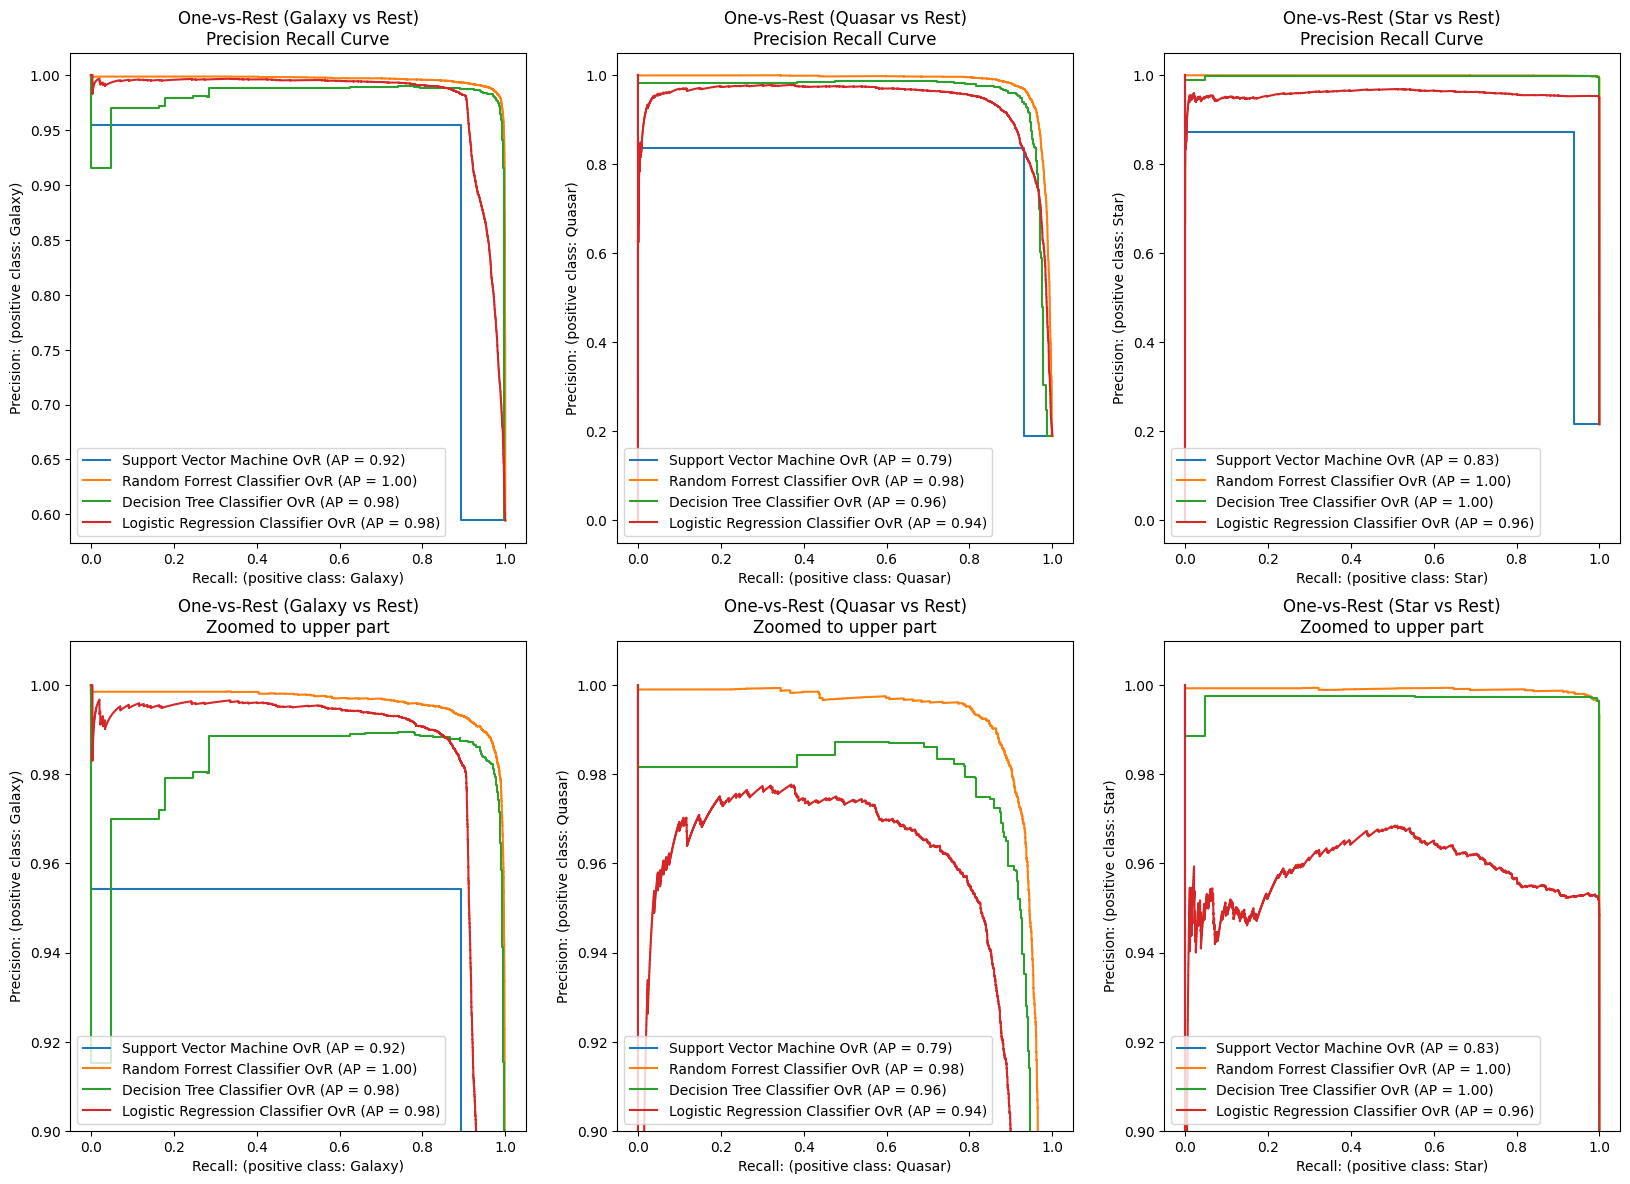

In [34]:
import matplotlib.pyplot as plt

# compare ovr roc curves for each model
"""
the mapping from labels to numbers is as follows
GALAXY  = 0 = [1, 0, 0]
QSO     = 1 = [0, 1, 0]
STAR    = 2 = [0, 0, 1]
"""

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

# for galaxy
for i, class_name in enumerate(["Galaxy", "Quasar", "Star"]):
    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        PrecisionRecallDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[0][i],

        )

    ax[0][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nPrecision Recall Curve")
    ax[0][i].set_xlabel(f"Recall: (positive class: {class_name})")
    ax[0][i].set_ylabel(f"Precision: (positive class: {class_name})")

    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        PrecisionRecallDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[1][i],

        )

    ax[1][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nZoomed to upper part")
    ax[1][i].set_xlabel(f"Recall: (positive class: {class_name})")
    ax[1][i].set_ylabel(f"Precision: (positive class: {class_name})")
    ax[1][i].set_ylim((0.9, 1.01))

According to the Precision Recall Curve, the Random Forrest classifier seems to be the overall best model (Orange line). The Support Vector Machine seems to be the least well performing since it is constantly
below all the other curves.

For Logistic Regression and the Decision Tree , this is not true. For Galaxy vs Rest, there are thresholds, when where the Logistic regression curve (red) is above the decision tree curve (green) but for the other two classes this is not true.
So for two out of three classes the Decision Tree is superior to the Logistic Regression and for one there are thresholds where logistic regression performs better.

## Analyze the ROC Curves for each Class individually
this helps to understand the overall classification performance among different thresholds

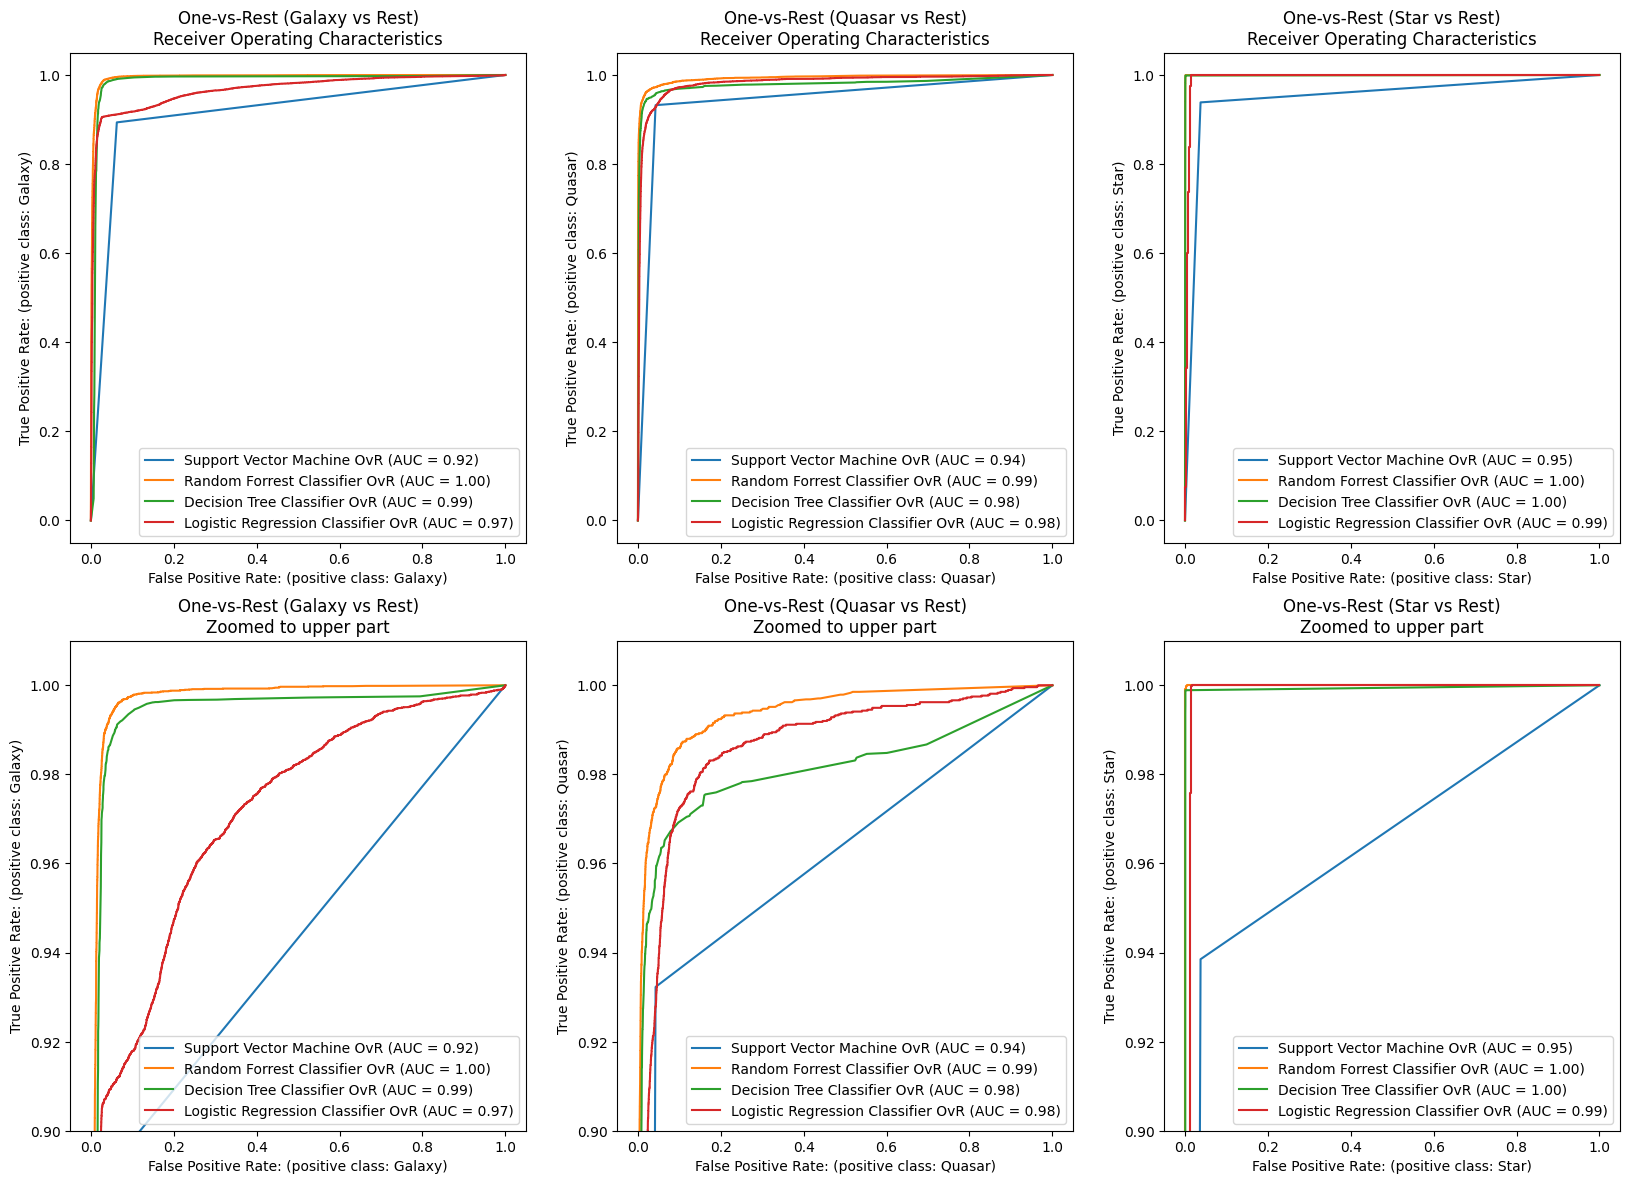

In [37]:
fig, ax = plt.subplots(2, 3, figsize=(20, 14))

# for galaxy
for i, class_name in enumerate(["Galaxy", "Quasar", "Star"]):
    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        RocCurveDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[0][i],

        )

    ax[0][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nReceiver Operating Characteristics")
    ax[0][i].set_xlabel(f"False Positive Rate: (positive class: {class_name})")
    ax[0][i].set_ylabel(f"True Positive Rate: (positive class: {class_name})")

    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        RocCurveDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[1][i],

        )

    ax[1][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nZoomed to upper part")
    ax[1][i].set_xlabel(f"False Positive Rate: (positive class: {class_name})")
    ax[1][i].set_ylabel(f"True Positive Rate: (positive class: {class_name})")
    ax[1][i].set_ylim((0.9, 1.01))

The ROC curves show a similar image than precision recall curve. The Random Forrest Classifier tends to be superior to all other models for all classes.
AS well as the Support Vector Machine tends to be Inferior.

Logistic Regression and Decision tree are not clearly superior or inferior, this differs for each threshold and feature, since the curves cross in for classes Quasar and Star.
For Galaxy, the decision tree seems to be superior to the logistic regression.

# Plot the feature weights of the logistic regression model

In [43]:
DataFrame(model_configurations["log_reg"]["estimator"].coef_, columns=model_configurations["log_reg"]["estimator"].feature_names_in_, index=["GALAXY", "QUASAR", "STAR"])

,u,g,r,i,z,redshift,plate
GALAXY,-0.655982,37.418284,-17.267620,-19.026330,-2.266228,-2.028246,-0.234537
QUASAR,-9.772450,-17.774947,-7.187026,31.503083,0.000000,42.745777,-0.838420
STAR,6.015968,-3.387429,0.000000,0.000000,0.904506,-1052.190694,0.300844


The table shows the feature weights of each feature for each class for the logistic regression.

In general, it turns out the plate number has low impact on all the classes. Which is not unexpected since in each area of the sky all the classes will be present.
For Galaxies, it seems that the green (g), red (r) and near infrared (i) filter value had the highest impact.

For Quasars, it was also the near infrared and green filed as well as the redshift.
For Stars the highest weight was given to the redshift while red and near infrared filter are not even considered.